<a href="https://colab.research.google.com/github/sa24mis/Proyecto-Herramientas-de-programacion-2-/blob/main/Macro_Petroleo_ML_robusto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install yfinance>=0.2.38 pandas>=2.0.0 numpy>=1.23.0 matplotlib>=3.7.0 scikit-learn>=1.2.0


In [ ]:
from __future__ import annotations
import warnings
from functools import lru_cache
from dataclasses import dataclass
from typing import Iterable, List, Tuple, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import yfinance as yf

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.grid'] = True

DEFAULT_RANDOM_STATE = 42
DEFAULT_US10Y = '^TNX'
DEFAULT_DXY  = 'DX-Y.NYB'
DEFAULT_SP500 = '^GSPC'
DEFAULT_WTI = 'CL=F'     # CRUDO WTI ($/bbl)
DEFAULT_BRENT = 'BZ=F'   # CRUDO BRENT ($/bbl)
DEFAULT_RBOB = 'RB=F'    # Gasolina RBOB ($/gal)
DEFAULT_HEATOIL = 'HO=F' # Heating Oil ($/gal)


In [ ]:
def _ensure_list(x) -> List[str]:
    if x is None:
        return []
    if isinstance(x, (list, tuple, set)):
        return list(x)
    return [x]

@lru_cache(maxsize=128)
def _download_cached(tickers_tuple: Tuple[str, ...], start: str, end: str, auto_adjust: bool = True) -> pd.DataFrame:
    return yf.download(list(tickers_tuple), start=start, end=end, auto_adjust=auto_adjust, progress=False, threads=True)

def _extract_close(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()
    if isinstance(df.columns, pd.MultiIndex):
        if 'Close' in df.columns.get_level_values(1):
            out = df.xs('Close', axis=1, level=1)
        else:
            tickers_lvl = df.columns.get_level_values(0).unique()
            cols = []
            for t in tickers_lvl:
                sub = df[t]
                if isinstance(sub, pd.DataFrame):
                    cols.append(sub.iloc[:, 0].rename(t))
                else:
                    cols.append(sub.rename(t))
            out = pd.concat(cols, axis=1)
    else:
        out = df[['Close']] if 'Close' in df.columns else df.iloc[:, [0]]
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index, errors='coerce')
    out = out[~out.index.isna()]
    out.index = out.index.tz_localize(None)
    return out.sort_index()

def bajar_df(tickers: Iterable[str], start: str, end: str) -> pd.DataFrame:
    tickers = tuple(_ensure_list(tickers))
    if len(tickers) == 0:
        raise ValueError('Debes pasar al menos un ticker.')
    if pd.to_datetime(start) >= pd.to_datetime(end):
        raise ValueError(f'Rango inválido: start={start} >= end={end}')
    dfraw = _download_cached(tickers, start, end, auto_adjust=True)
    if dfraw.empty:
        raise ValueError(f'Sin datos para {tickers} entre {start}–{end}.')
    close = _extract_close(dfraw)
    if len(close.columns) == len(tickers):
        close.columns = list(tickers)
    return close.dropna(how='all')

def bajar_serie(ticker: str, start: str, end: str) -> pd.Series:
    df = bajar_df([ticker], start, end)
    s = df.iloc[:, 0]
    s.name = ticker
    return s

def pct_ret(s: pd.Series, kind: str='simple') -> pd.Series:
    s = s.dropna()
    return np.log(s).diff() if kind=='log' else s.pct_change()

def _monthly_returns(s: pd.Series) -> pd.Series:
    return s.resample('M').last().pct_change()


In [ ]:
def mercado_dashboard(ticker: str, start: str, end: str) -> None:
    px = bajar_serie(ticker, start, end)
    fig1, ax1 = plt.subplots(); ax1.plot(px.index, px.values)
    ax1.set_title(f'Precio de cierre - {ticker}'); ax1.set_xlabel('Fecha'); ax1.set_ylabel('Precio'); fig1.tight_layout()
    rm = _monthly_returns(px).dropna()
    fig2, ax2 = plt.subplots(); ax2.bar(rm.index, rm.values); ax2.axhline(0, linestyle='--')
    ax2.set_title(f'Retorno mensual - {ticker}'); ax2.set_xlabel('Mes'); ax2.set_ylabel('Retorno'); fig2.autofmt_xdate(); fig2.tight_layout()
    plt.show()


## Dashboard **Petróleo** (WTI, Brent, spread, crack 3:2:1, betas)

In [ ]:
def crack_spread_321(wti_bbl: pd.Series, rb_gal: pd.Series, ho_gal: pd.Series) -> pd.Series:
    # 3 bbl crudo → 2 gasolina + 1 destilado; convertir gal→bbl (42 gal = 1 bbl)
    # precios: WTI en $/bbl, RBOB/HO en $/gal
    cs = (2 * rb_gal * 42 + 1 * ho_gal * 42) - 3 * wti_bbl
    cs.name = 'crack_321_$/bbl'
    return cs

def oil_dashboard(
    ticker_asset: str,
    start: str,
    end: str,
    wti: str = DEFAULT_WTI,
    brent: str = DEFAULT_BRENT,
    rb: str = DEFAULT_RBOB,
    ho: str = DEFAULT_HEATOIL,
    roll_window: int = 60,
) -> Dict[str, pd.Series]:
    asset = bajar_serie(ticker_asset, start, end)
    wti_s = bajar_serie(wti, start, end)
    brent_s = bajar_serie(brent, start, end)
    rb_s = bajar_serie(rb, start, end)
    ho_s = bajar_serie(ho, start, end)

    spread = (brent_s - wti_s).rename('Brent-WTI ($/bbl)')
    crack = crack_spread_321(wti_s, rb_s, ho_s)

    # 1) WTI & Brent
    fig, ax = plt.subplots(); ax.plot(wti_s.index, wti_s.values, label='WTI (CL=F)'); ax.plot(brent_s.index, brent_s.values, label='Brent (BZ=F)')
    ax.set_title('Crudo: WTI vs Brent ($/bbl)'); ax.set_ylabel('$ / bbl'); ax.legend(); fig.tight_layout(); plt.show()

    # 2) Spread Brent-WTI
    fig2, ax2 = plt.subplots(); ax2.plot(spread.index, spread.values); ax2.set_title('Spread Brent–WTI ($/bbl)'); ax2.set_ylabel('$ / bbl'); fig2.tight_layout(); plt.show()

    # 3) Crack spread 3:2:1
    fig3, ax3 = plt.subplots(); ax3.plot(crack.index, crack.values); ax3.set_title('Crack spread 3:2:1 ($/bbl)'); ax3.set_ylabel('$ / bbl'); fig3.tight_layout(); plt.show()

    # 4) Sensibilidad del activo a WTI (scatter + beta)
    ret_a = pct_ret(asset); ret_wti = pct_ret(wti_s)
    df = pd.concat([ret_a.rename('ret_asset'), ret_wti.rename('ret_wti')], axis=1).dropna()
    if len(df) > 10:
        beta = np.polyfit(df['ret_wti'], df['ret_asset'], 1)[0]
        r2 = np.corrcoef(df['ret_wti'], df['ret_asset'])[0,1]**2
    else:
        beta, r2 = np.nan, np.nan
    fig4, ax4 = plt.subplots(); ax4.scatter(df['ret_wti'], df['ret_asset'], s=10)
    ax4.set_title(f'Scatter retornos: Activo vs WTI (beta≈{beta:.2f}, R²≈{r2:.2f})')
    ax4.set_xlabel('ret WTI'); ax4.set_ylabel('ret Activo'); fig4.tight_layout(); plt.show()

    # 5) Correlación y beta rodante (roll_window)
    roll_corr = df['ret_asset'].rolling(roll_window).corr(df['ret_wti']).rename(f'corr_{roll_window}d')
    # rolling beta: cov/var
    cov = df['ret_asset'].rolling(roll_window).cov(df['ret_wti'])
    var = df['ret_wti'].rolling(roll_window).var()
    roll_beta = (cov/var).rename(f'beta_{roll_window}d')
    fig5, ax5 = plt.subplots(); ax5.plot(roll_corr.index, roll_corr.values); ax5.set_title(f'Correlación {roll_window}d Activo–WTI'); fig5.tight_layout(); plt.show()
    fig6, ax6 = plt.subplots(); ax6.plot(roll_beta.index, roll_beta.values); ax6.set_title(f'Beta {roll_window}d vs WTI'); fig6.tight_layout(); plt.show()

    return {'wti': wti_s, 'brent': brent_s, 'spread': spread, 'crack321': crack, 'roll_corr': roll_corr, 'roll_beta': roll_beta}


In [ ]:
def macro_dashboard_petro(
    ticker: str,
    start: str,
    end: str,
    us10y: str = DEFAULT_US10Y,
    dxy: str = DEFAULT_DXY,
    wti: str = DEFAULT_WTI,
    brent: str = DEFAULT_BRENT,
    market: str = DEFAULT_SP500,
) -> None:
    a = bajar_serie(ticker, start, end)
    try:
        y10 = bajar_serie(us10y, start, end) / 10.0
    except Exception as e:
        warnings.warn(f'No se pudo bajar {us10y}: {e}'); y10 = pd.Series(dtype=float)
    try:
        dx = bajar_serie(dxy, start, end)
    except Exception:
        warnings.warn("Falla DXY; probando 'DXY' y 'UUP'")
        try: dx = bajar_serie('DXY', start, end)
        except Exception: dx = bajar_serie('UUP', start, end)
    mkt = bajar_serie(market, start, end)
    wti_s = bajar_serie(wti, start, end)
    brent_s = bajar_serie(brent, start, end)

    fig, ax1 = plt.subplots(); ax1.plot(a.index, a.values, label=f'{ticker}')
    ax1.set_ylabel(f'{ticker}'); ax2 = ax1.twinx()
    if not y10.empty:
        ax2.plot(y10.index, y10.values, linestyle='--', label='US 10Y (%)'); ax2.invert_yaxis(); ax2.set_ylabel('US 10Y (%) - invertido')
    ax1.set_title(f'{ticker} vs 10Y (invertido)'); fig.tight_layout(); plt.show()

    fig2, ax2b = plt.subplots(); ax2b.plot(dx.index, dx.values); ax2b.set_title('Dollar Index (DXY)'); fig2.tight_layout(); plt.show()

    fig3, ax3 = plt.subplots(); ax3.plot(wti_s.index, wti_s.values, label='WTI'); ax3.plot(brent_s.index, brent_s.values, label='Brent')
    ax3.set_title('Petróleo: WTI y Brent ($/bbl)'); ax3.set_ylabel('$ / bbl'); ax3.legend(); fig3.tight_layout(); plt.show()

    fig4, ax4 = plt.subplots(); ax4.plot(mkt.index, mkt.values); ax4.set_title('Mercado: S&P 500'); fig4.tight_layout(); plt.show()


## Dataset de forecast con features petroleras (WTI, Brent, crack spread)

In [ ]:
@dataclass
class ForecastDataset:
    X: pd.DataFrame
    y: pd.Series
    last_price: float
    last_date: pd.Timestamp

def dataset_petro_para_forecast(
    ticker: str,
    start: str,
    end: str,
    lags: int = 3,
    market: str = DEFAULT_SP500,
    us10y: str = DEFAULT_US10Y,
    dxy: str = DEFAULT_DXY,
    wti: str = DEFAULT_WTI,
    brent: str = DEFAULT_BRENT,
    rb: str = DEFAULT_RBOB,
    ho: str = DEFAULT_HEATOIL,
) -> ForecastDataset:
    a = bajar_serie(ticker, start, end)
    mkt = bajar_serie(market, start, end)
    try:
        y10 = bajar_serie(us10y, start, end) / 10.0
    except Exception as e:
        warnings.warn(f'No se pudo bajar {us10y}: {e}'); y10 = pd.Series(dtype=float)
    try:
        dx = bajar_serie(dxy, start, end)
    except Exception:
        try: dx = bajar_serie('DXY', start, end)
        except Exception: dx = bajar_serie('UUP', start, end)
    wti_s = bajar_serie(wti, start, end)
    brent_s = bajar_serie(brent, start, end)
    rb_s = bajar_serie(rb, start, end)
    ho_s = bajar_serie(ho, start, end)

    ret_a   = pct_ret(a).rename('ret_asset')
    ret_mkt = pct_ret(mkt).rename('ret_mkt')
    d_tnx_pp = y10.diff().rename('d_tnx_pp')
    ret_dxy = pct_ret(dx).rename('ret_dxy')
    ret_wti = pct_ret(wti_s).rename('ret_wti')
    ret_bre = pct_ret(brent_s).rename('ret_brent')
    crack = crack_spread_321(wti_s, rb_s, ho_s)
    ret_crack = pct_ret(crack).rename('ret_crack321')

    # Evitar look-ahead: macro & oil shift(1)
    d_tnx_pp = d_tnx_pp.shift(1)
    ret_dxy  = ret_dxy.shift(1)
    ret_mkt  = ret_mkt.shift(1)
    ret_wti  = ret_wti.shift(1)
    ret_bre  = ret_bre.shift(1)
    ret_crack = ret_crack.shift(1)

    df = pd.concat([ret_a, d_tnx_pp, ret_dxy, ret_mkt, ret_wti, ret_bre, ret_crack], axis=1)
    for k in range(1, lags+1):
        df[f'ret_asset_lag{k}'] = ret_a.shift(k)
    df = df.dropna()
    y = df['ret_asset'].copy()
    X = df.drop(columns=['ret_asset']).copy()
    return ForecastDataset(X=X, y=y, last_price=float(a.dropna().iloc[-1]), last_date=a.dropna().index[-1])


In [ ]:
@dataclass
class FittedModel:
    model: Ridge
    scaler: StandardScaler
    features: List[str]

def fit_modelo_retorno(X: pd.DataFrame, y: pd.Series, alpha: float = 0.5) -> FittedModel:
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X.values)
    m = Ridge(alpha=alpha, random_state=DEFAULT_RANDOM_STATE)
    m.fit(Xs, y.values)
    return FittedModel(model=m, scaler=scaler, features=list(X.columns))

def predict_modelo(fm: FittedModel, X: pd.DataFrame) -> np.ndarray:
    X = X[fm.features]
    Xs = fm.scaler.transform(X.values)
    return fm.model.predict(Xs)

def eval_ts_cv(X: pd.DataFrame, y: pd.Series, alpha: float = 0.5, n_splits: int = 5) -> Dict[str, float]:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mses, maes, r2s = [], [], []
    for tr, te in tscv.split(X):
        fm = fit_modelo_retorno(X.iloc[tr], y.iloc[tr], alpha=alpha)
        pred = predict_modelo(fm, X.iloc[te])
        y_true = y.iloc[te].values
        mses.append(mean_squared_error(y_true, pred))
        maes.append(mean_absolute_error(y_true, pred))
        r2s.append(r2_score(y_true, pred))
    return {'cv_mse_mean': float(np.mean(mses)), 'cv_mse_std': float(np.std(mses)),
            'cv_mae_mean': float(np.mean(maes)), 'cv_mae_std': float(np.std(maes)),
            'cv_r2_mean': float(np.mean(r2s)), 'cv_r2_std': float(np.std(r2s))}


In [ ]:
def _estimate_ar1(residuals: pd.Series) -> Tuple[float, float]:
    x = residuals.dropna().values
    if len(x) < 3:
        return 0.0, float(np.std(x) if len(x) else 0.01)
    x = x - x.mean()
    x_lag = np.roll(x, 1)[1:]
    y = x[1:]
    phi = (x_lag @ y) / (x_lag @ x_lag + 1e-12)
    eps = y - phi * x_lag
    sigma = float(np.std(eps))
    return float(phi), sigma

def proyecta_precio_hasta_2030(
    ticker: str,
    start: str,
    end: str,
    horizon: str = '2030-12-31',
    lags: int = 3,
    alpha: float = 0.5,
    scenario: str = 'base',  # base | hawkish | dovish | oil_up | oil_down
    random_state: int = DEFAULT_RANDOM_STATE,
) -> pd.DataFrame:
    np.random.seed(random_state)
    ds = dataset_petro_para_forecast(ticker, start, end, lags=lags)
    X, y = ds.X, ds.y
    fm = fit_modelo_retorno(X, y, alpha=alpha)

    hist = pd.concat([X, y.rename('ret_asset')], axis=1).dropna()
    mu = hist.mean()
    phi_dxy, sig_dxy = _estimate_ar1(hist['ret_dxy'] - hist['ret_dxy'].mean())
    phi_mkt, sig_mkt = _estimate_ar1(hist['ret_mkt'] - hist['ret_mkt'].mean())
    phi_tnx, sig_tnx = _estimate_ar1(hist['d_tnx_pp'] - hist['d_tnx_pp'].mean())
    phi_wti, sig_wti = _estimate_ar1(hist['ret_wti'] - hist['ret_wti'].mean())
    phi_bre, sig_bre = _estimate_ar1(hist['ret_brent'] - hist['ret_brent'].mean())
    phi_crk, sig_crk = _estimate_ar1(hist['ret_crack321'] - hist['ret_crack321'].mean())

    horizon_dt = pd.to_datetime(horizon)
    last_dt = ds.last_date
    if horizon_dt <= last_dt:
        raise ValueError(f'La fecha horizonte ({horizon}) debe ser posterior a {last_dt.date()}.')
    idx = pd.bdate_range(start=last_dt + pd.Timedelta(days=1), end=horizon_dt, freq='B')

    price = ds.last_price
    ret_hist = hist['ret_asset'].copy()
    last_lags = [float(ret_hist.iloc[-k]) for k in range(1, lags + 1)]

    outs = {'price': [], 'ret': [], 'd_tnx_pp': [], 'ret_dxy': [], 'ret_mkt': [], 'ret_wti': [], 'ret_brent': [], 'ret_crack321': []}

    d_tnx = float(mu.get('d_tnx_pp', 0.0))
    r_dxy = float(mu.get('ret_dxy', 0.0))
    r_mkt = float(mu.get('ret_mkt', 0.0))
    r_wti = float(mu.get('ret_wti', 0.0))
    r_bre = float(mu.get('ret_brent', 0.0))
    r_crk = float(mu.get('ret_crack321', 0.0))

    # Drifts por escenario
    drift_tnx = 0.0; drift_dxy = 0.0; drift_wti = 0.0; drift_bre = 0.0; drift_crk = 0.0
    if scenario == 'hawkish':
        drift_tnx = 0.02; drift_dxy = 0.0002
    elif scenario == 'dovish':
        drift_tnx = -0.02; drift_dxy = -0.0002
    elif scenario == 'oil_up':
        drift_wti = 0.001; drift_bre = 0.001; drift_crk = 0.0005  # +0.1% diario WTI/Brent aprox
    elif scenario == 'oil_down':
        drift_wti = -0.001; drift_bre = -0.001; drift_crk = -0.0005

    for _ in idx:
        d_tnx = (mu['d_tnx_pp'] + drift_tnx) + phi_tnx * (d_tnx - mu['d_tnx_pp']) + np.random.normal(0, sig_tnx or 1e-4)
        r_dxy = (mu['ret_dxy'] + drift_dxy) + phi_dxy * (r_dxy - mu['ret_dxy']) + np.random.normal(0, sig_dxy or 1e-4)
        r_mkt = mu['ret_mkt'] + phi_mkt * (r_mkt - mu['ret_mkt']) + np.random.normal(0, sig_mkt or 1e-4)
        r_wti = (mu['ret_wti'] + drift_wti) + phi_wti * (r_wti - mu['ret_wti']) + np.random.normal(0, sig_wti or 1e-4)
        r_bre = (mu['ret_brent'] + drift_bre) + phi_bre * (r_bre - mu['ret_brent']) + np.random.normal(0, sig_bre or 1e-4)
        r_crk = (mu['ret_crack321'] + drift_crk) + phi_crk * (r_crk - mu['ret_crack321']) + np.random.normal(0, sig_crk or 1e-4)

        feat = { 'd_tnx_pp': d_tnx, 'ret_dxy': r_dxy, 'ret_mkt': r_mkt, 'ret_wti': r_wti, 'ret_brent': r_bre, 'ret_crack321': r_crk }
        for k in range(1, lags + 1):
            feat[f'ret_asset_lag{k}'] = last_lags[k - 1]
        X_row = pd.DataFrame([feat], columns=fm.features)
        r_asset = float(predict_modelo(fm, X_row)[0])
        price = price * (1.0 + r_asset)
        last_lags = [r_asset] + last_lags[:-1]

        outs['price'].append(price); outs['ret'].append(r_asset)
        outs['d_tnx_pp'].append(d_tnx); outs['ret_dxy'].append(r_dxy); outs['ret_mkt'].append(r_mkt)
        outs['ret_wti'].append(r_wti); outs['ret_brent'].append(r_bre); outs['ret_crack321'].append(r_crk)

    outdf = pd.DataFrame(outs, index=idx)
    return outdf

def plot_pred_path(path_df: pd.DataFrame, ticker: str, last_price: float) -> None:
    fig, ax = plt.subplots(); ax.plot(path_df.index, path_df['price'].values, label='Precio simulado')
    ax.axhline(last_price, linestyle='--', label='Precio inicial'); ax.set_title(f'Proyección simulada de {ticker}')
    ax.set_ylabel('Precio'); ax.legend(); fig.autofmt_xdate(); fig.tight_layout(); plt.show()


## Parámetros de usuario

In [ ]:
from datetime import date
TICKER = 'EC'            # activo a analizar (Ecopetrol, p.ej.)
START  = '2015-01-01'
END    = date.today().isoformat()
LAGS   = 3
ALPHA  = 0.5
ROLL_WIN = 60
SCENARIO = 'oil_up'      # 'base' | 'hawkish' | 'dovish' | 'oil_up' | 'oil_down'
HORIZON  = '2030-12-31'


## 1) Dashboard de mercado del activo

/tmp/ipython-input-2535520662.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return s.resample('M').last().pct_change()


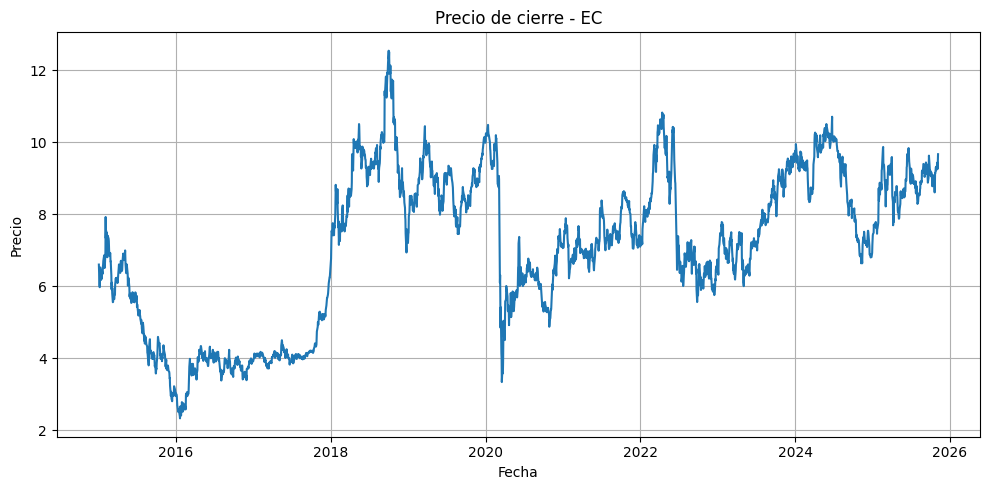

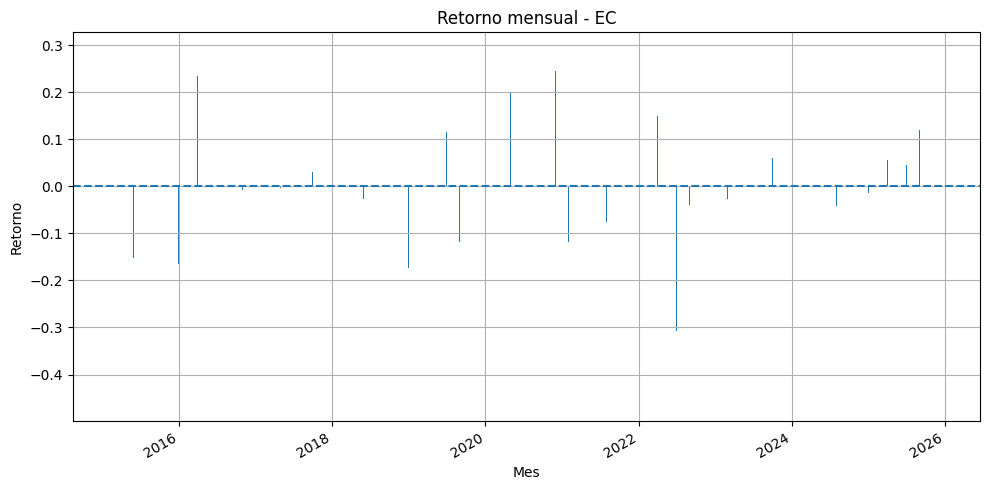

In [ ]:
mercado_dashboard(TICKER, START, END)

## 2) Dashboard **petróleo** (WTI, Brent, spread, crack, betas)

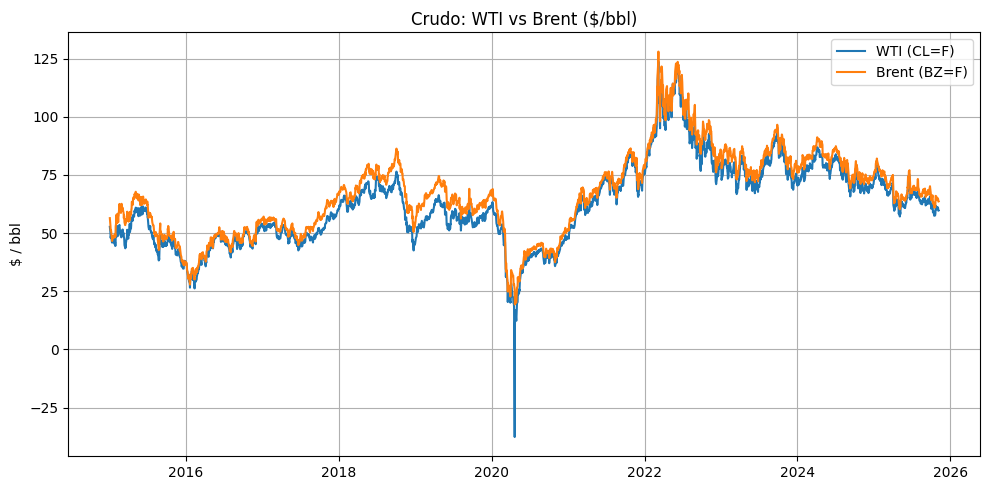

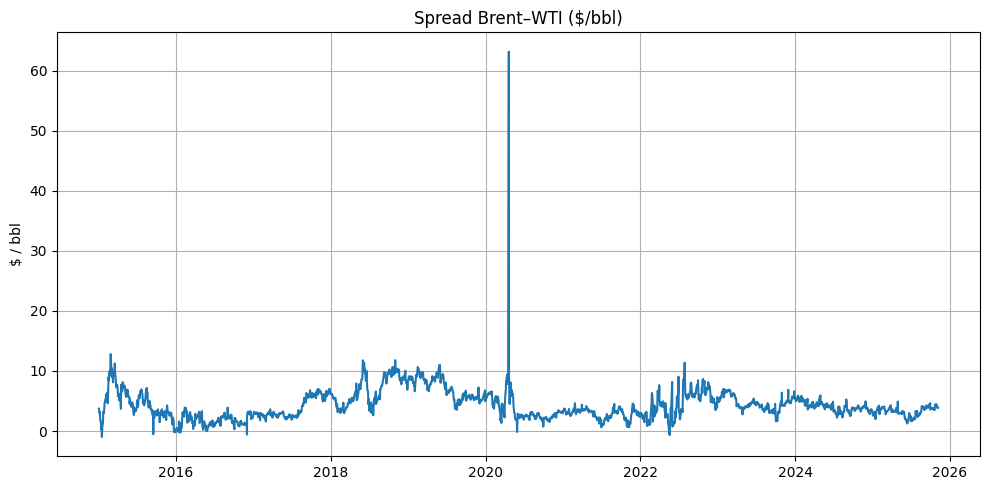

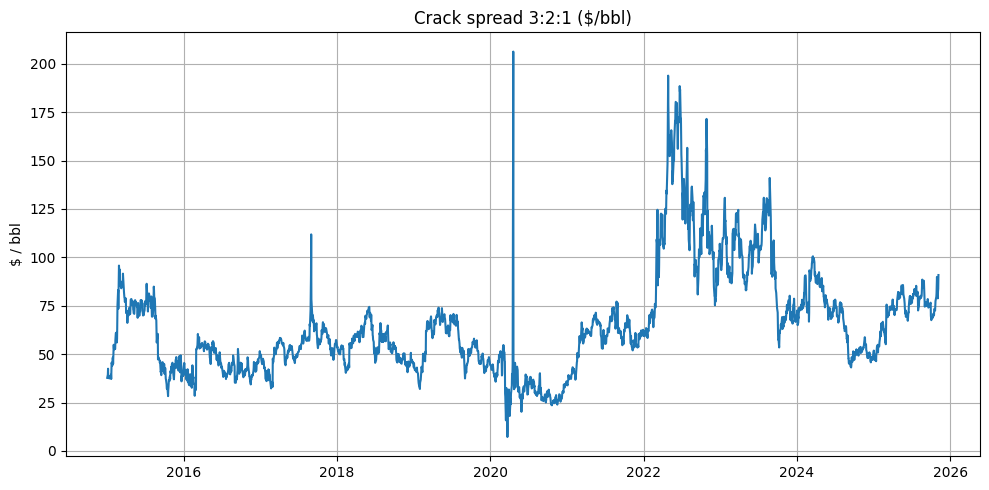

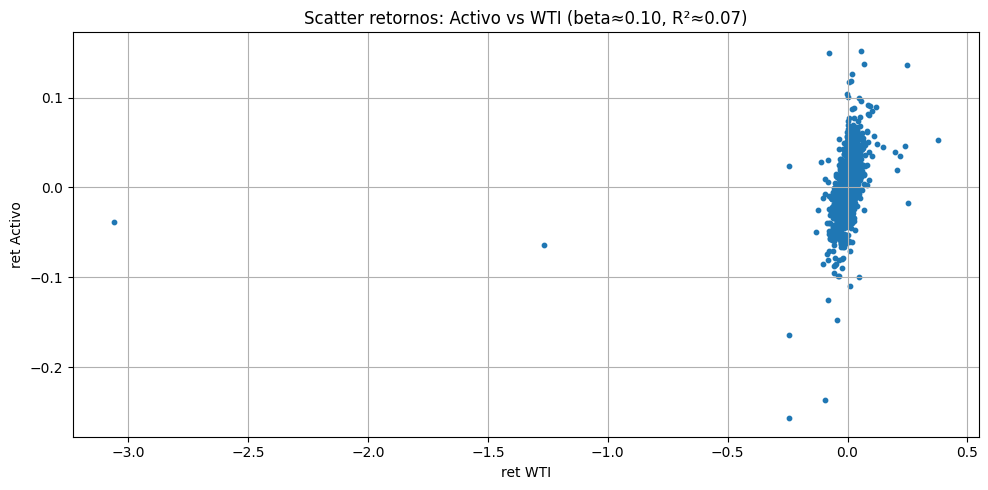

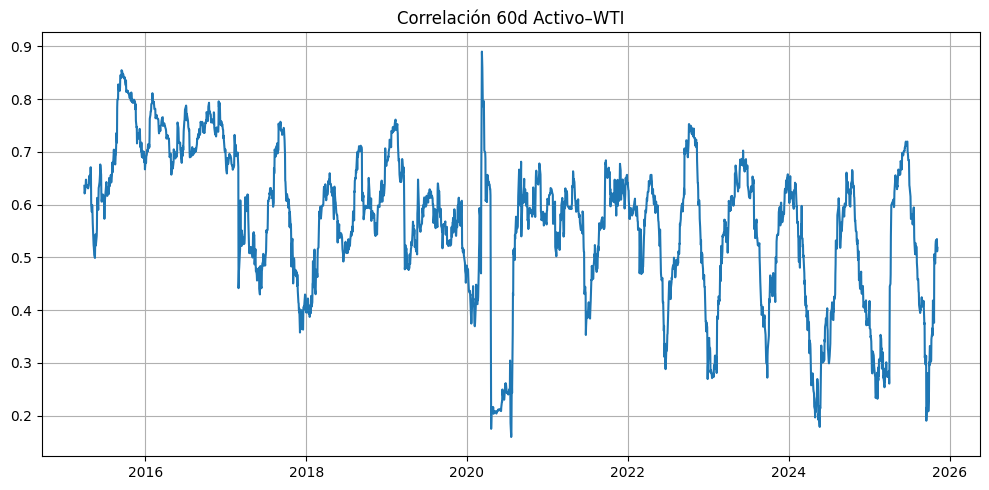

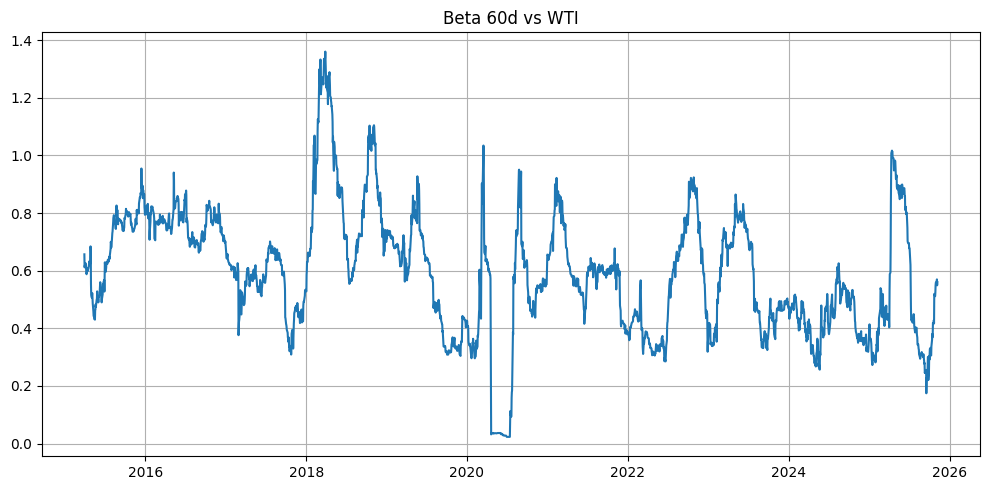

{'wti': Date
 2015-01-02    52.689999
 2015-01-05    50.040001
 2015-01-06    47.930000
 2015-01-07    48.650002
 2015-01-08    48.790001
                 ...    
 2025-10-31    60.980000
 2025-11-03    61.049999
 2025-11-04    60.560001
 2025-11-05    59.599998
 2025-11-06    59.680000
 Name: CL=F, Length: 2729, dtype: float64,
 'brent': Date
 2015-01-02    56.419998
 2015-01-05    53.110001
 2015-01-06    51.099998
 2015-01-07    51.150002
 2015-01-08    50.959999
                 ...    
 2025-10-31    65.070000
 2025-11-03    64.889999
 2025-11-04    64.440002
 2025-11-05    63.520000
 2025-11-06    63.590000
 Name: BZ=F, Length: 2730, dtype: float64,
 'spread': Date
 2015-01-02    3.730000
 2015-01-05    3.070000
 2015-01-06    3.169998
 2015-01-07    2.500000
 2015-01-08    2.169998
                 ...   
 2025-10-31    4.090000
 2025-11-03    3.840000
 2025-11-04    3.880001
 2025-11-05    3.920002
 2025-11-06    3.910000
 Name: Brent-WTI ($/bbl), Length: 2730, dtype: float64,


In [ ]:
oil_dashboard(TICKER, START, END, roll_window=ROLL_WIN)

## 3) Dashboard macro (tasas, dólar, mercado, petróleo)

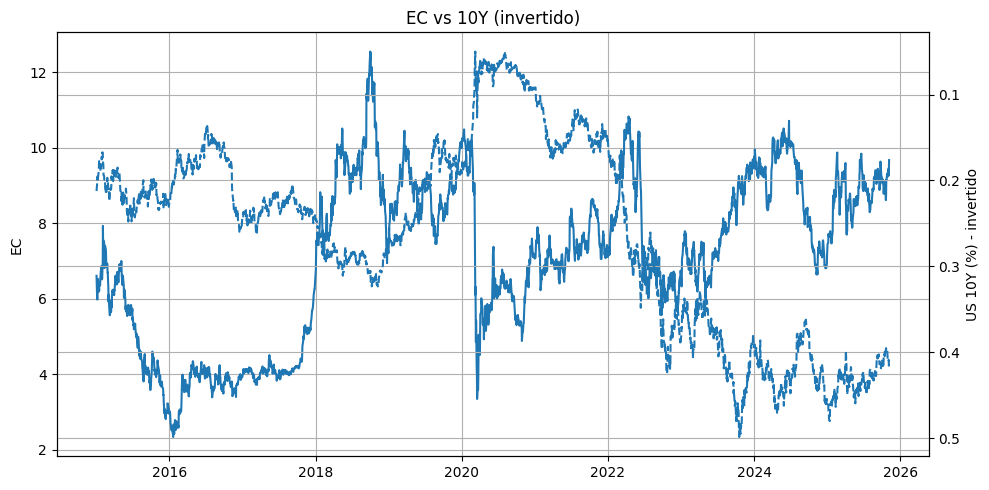

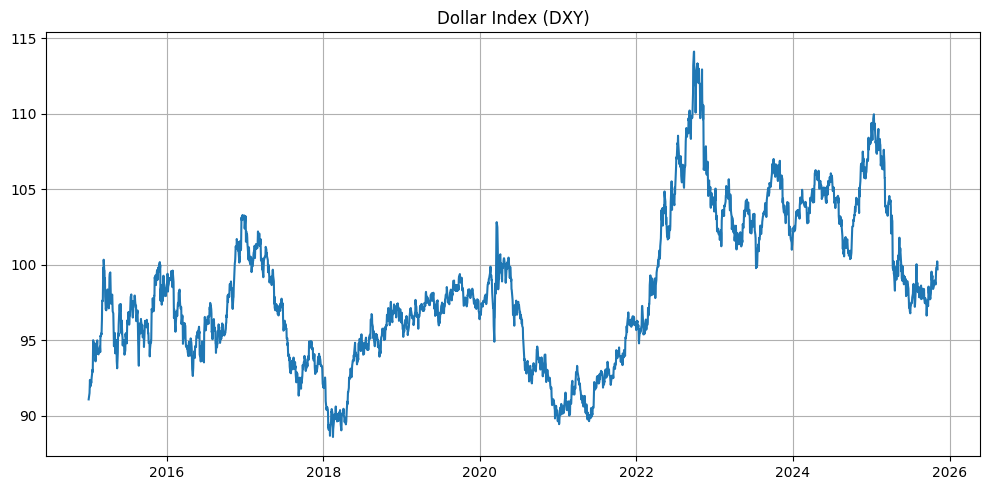

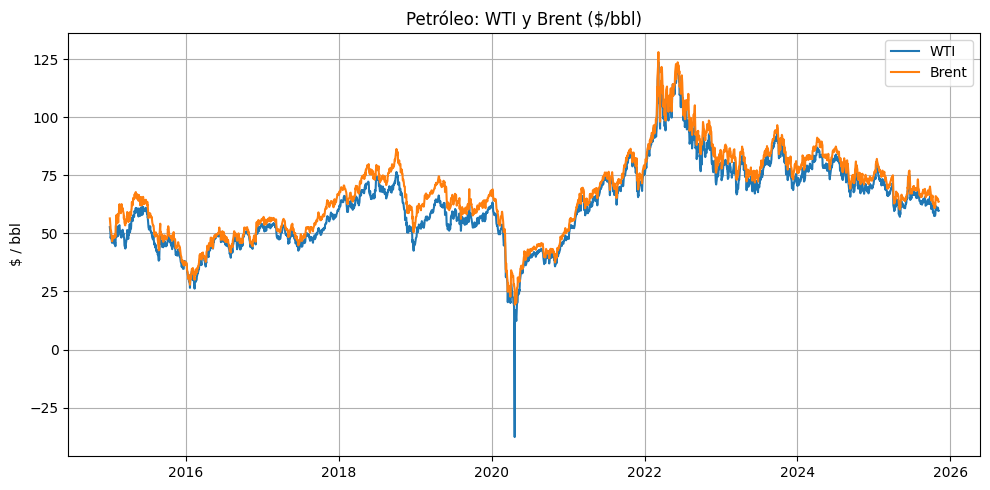

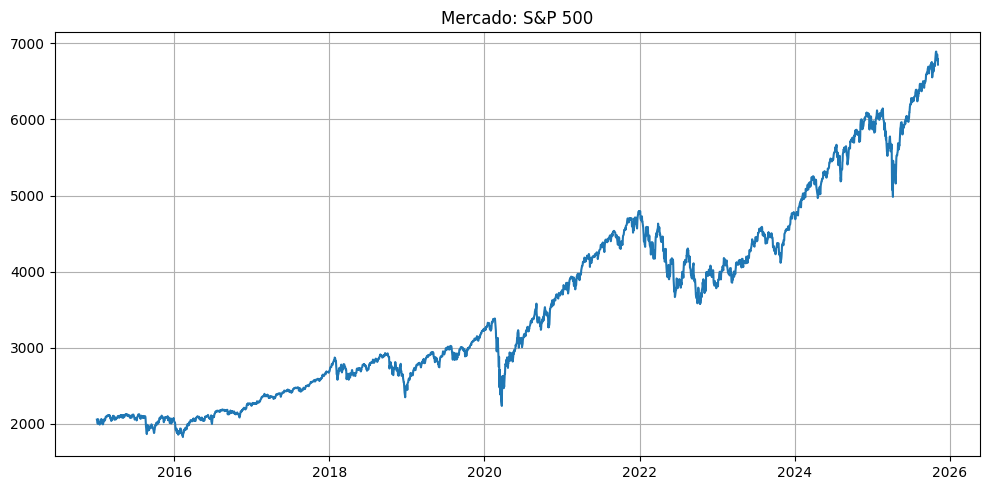

In [ ]:
macro_dashboard_petro(TICKER, START, END)

## 4) Dataset con features petroleras + Validación temporal

In [ ]:
ds = dataset_petro_para_forecast(TICKER, START, END, lags=LAGS)
eval_ts_cv(ds.X, ds.y, alpha=ALPHA, n_splits=5)

{'cv_mse_mean': 0.000695967365725484,
 'cv_mse_std': 0.0003591611603129599,
 'cv_mae_mean': 0.018015831933954833,
 'cv_mae_std': 0.002873834305592617,
 'cv_r2_mean': -0.04101604479891265,
 'cv_r2_std': 0.041476077604304815}

## 5) Proyección hasta 2030 con escenarios petroleros + gráfica

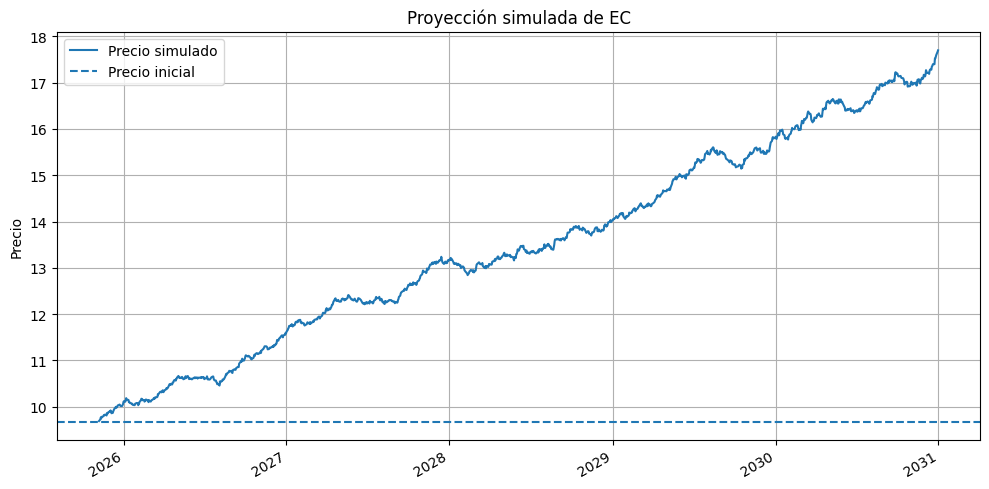

,price,ret,d_tnx_pp,ret_dxy,ret_mkt,ret_wti,ret_brent,ret_crack321
2025-11-07,9.690972,0.002169,0.002766,-0.000566,0.007779,0.102064,-0.004421,-0.017814
2025-11-10,9.727016,0.003719,0.008598,0.003425,-0.005744,0.065179,-0.010153,-0.037145
2025-11-11,9.768201,0.004234,0.001324,-0.008352,-0.017983,-0.019064,-0.023850,0.035752
2025-11-12,9.748775,-0.001989,-0.004838,-0.006331,0.019479,-0.020060,0.002914,-0.129365
2025-11-13,9.783549,0.003567,-0.002825,0.000431,-0.014986,0.019917,-0.013514,-0.011558


In [ ]:
path = proyecta_precio_hasta_2030(TICKER, START, END, horizon=HORIZON, lags=LAGS, alpha=ALPHA, scenario=SCENARIO)
plot_pred_path(path, TICKER, ds.last_price)
path.head()